In [2]:
import yfinance as yf 
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import confusion_matrix
from yellowbrick.model_selection import FeatureImportances

In [3]:
end_date = dt.datetime.now().date()
start_date = end_date - dt.timedelta(3650)
prediction_duration = 10
stock_name='TCS.NS'
stock = yf.Ticker(stock_name).history( start=start_date, end=end_date, auto_adjust=False)

In [4]:
training_data = stock[['Adj Close']]
training_data=training_data.rename({'Adj Close':'close'}, axis =1)
training_data ['high']= stock['High']
training_data ['low']= stock['Low']
training_data ['open']= stock['Open']
training_data ['volume']= stock['Volume']
training_data.ta.strategy('momentum')

In [6]:
df = training_data

In [7]:
df["Ret"] = df["close"].pct_change()
df.reset_index(inplace=True)
name = "Ret"

In [8]:
df["Ret"] = df["close"].pct_change()
df.reset_index(inplace=True)
name = "Ret"

In [9]:
ret_fieldi=f"Ret{prediction_duration}_i"
ret_field=f"Ret{prediction_duration}"
df[ ret_fieldi] = df[name].rolling(prediction_duration).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1))
df[ret_field] = df[ret_fieldi].shift(-prediction_duration)
df["Output"] = df[ret_field].apply(lambda x :1 if  x > 0 else -1 )
df["Output"] = df["Output"].astype(int)
del df[ret_field]

In [13]:
del df['BR_26']

In [14]:
df=df.fillna(0)
X= df.iloc[:,6:-3]
y = df.iloc[:,-1]
classes = [1,-1]

In [15]:
X_train , X_test, y_train, y_test = train_test_split(X,y,test_size=.2,shuffle=False)

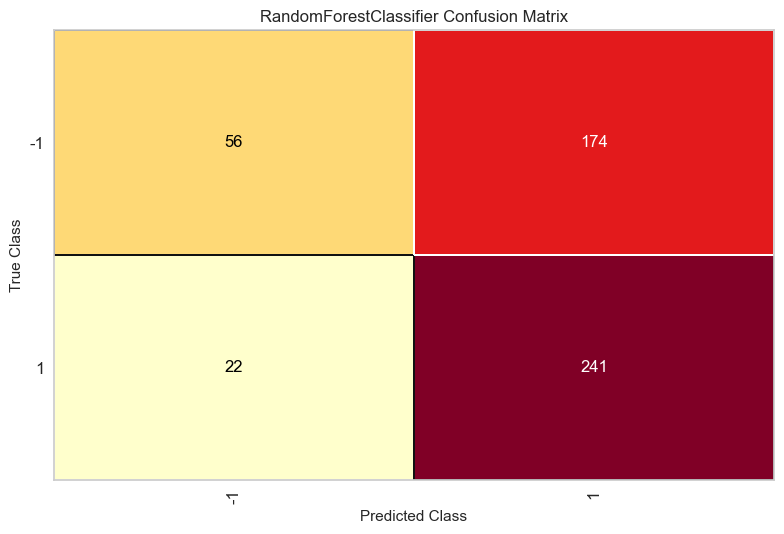

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [16]:
# The ConfusionMatrix visualizer taxes a model
model =RandomForestClassifier()
cm = ConfusionMatrix(model)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

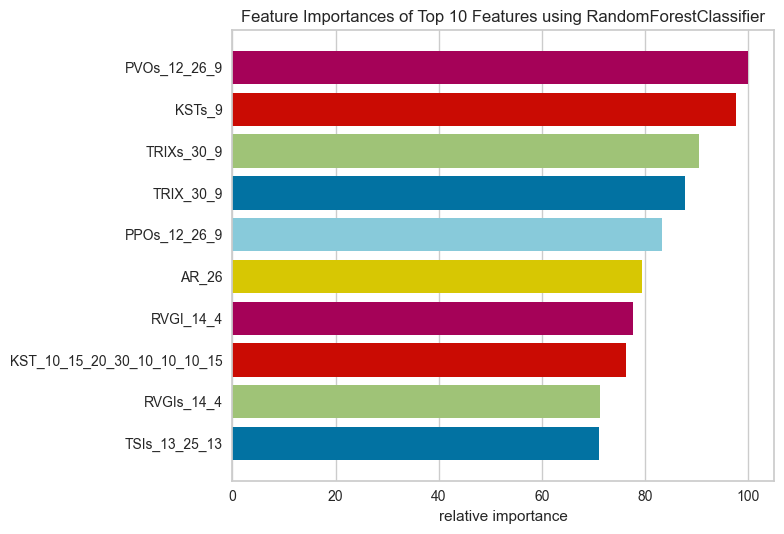

<Axes: title={'center': 'Feature Importances of Top 10 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [17]:

model = RandomForestClassifier()
viz = FeatureImportances(model, topn = 10)
viz.fit(X, y)
viz.show()

y_pred=model.predict(X_test)
y_test

/Users/shritiwari/opt/anaconda3/envs/push/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shritiwari/opt/anaconda3/envs/push/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


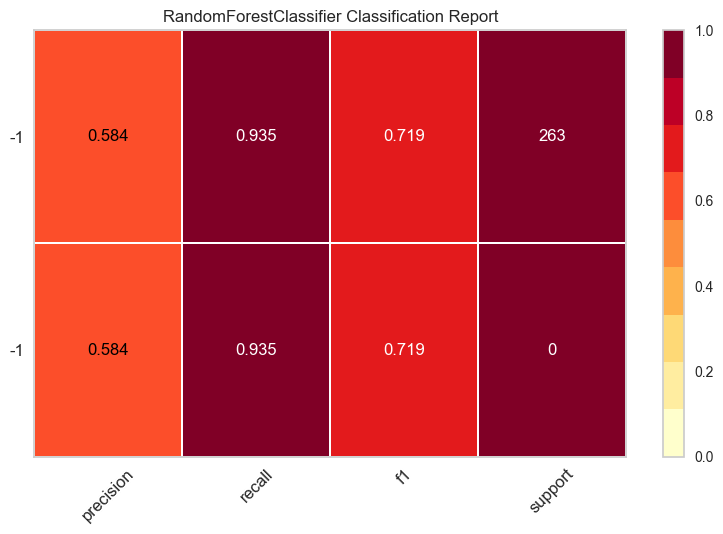

<Axes: title={'center': 'RandomForestClassifier Classification Report'}>

In [19]:
model = RandomForestClassifier()
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()  

In [20]:
df['Pred'] = model.predict(df[X.columns])
df["Positions"] = np.where(df["Pred"] > 0.5, 1, -1)
df["Strat_ret"] = df["Positions"].shift(1) * df["Ret"]
df["Positions_L"] = df["Positions"].shift(1)
df["Positions_L"][df["Positions_L"] == -1] = 0
df["Strat_ret_L"] = df["Positions_L"] * df["Ret"]
df["CumRet"] = df["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df["CumRet_L"] = df["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df["bhRet"] = df["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Return =", Final_Return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")

/var/folders/mk/pkqnv_dx053g95zwc3mj01b00000gn/T/ipykernel_86443/1993079715.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Positions_L"][df["Positions_L"] == -1] = 0


Strat Return Long Only = 11036.46003810807 %
Strat Return = 219716.12124564225 %
Buy and Hold Return = 355.964251770871 %


<Axes: >

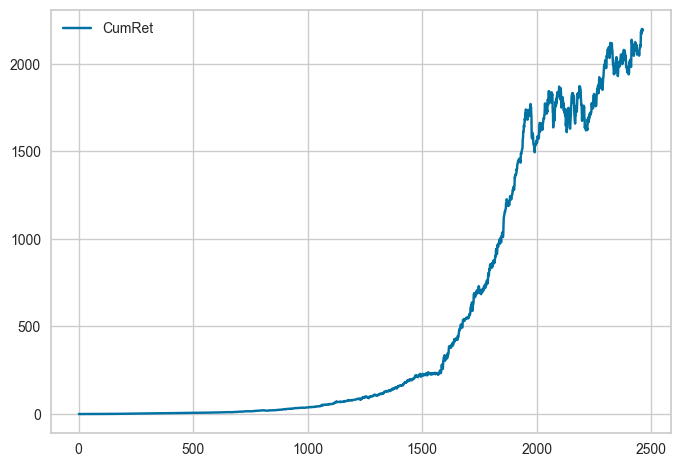

In [24]:
df[["CumRet"]].plot()

<Axes: >

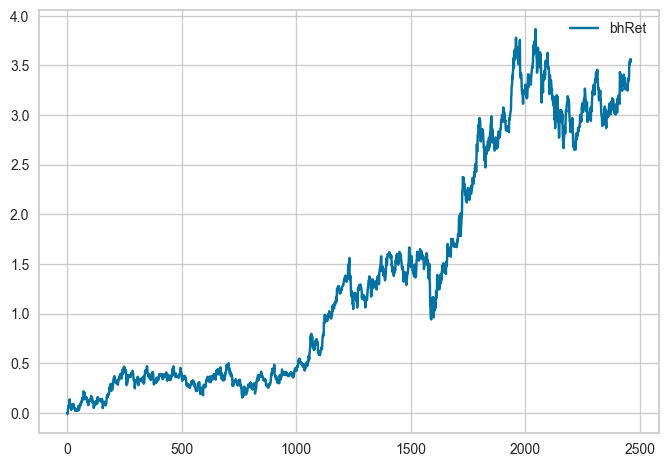

In [25]:
df[["bhRet"]].plot()

In [26]:
ret=df.CumRet
ret.mean()/ret.std()

0.7285324433495227